# Medical Image Segmentation: Basics

Please first check if matplotlib and scipy packages are installed.
Several basic tools exist in medical image segmentation. Even if you use an advanced machine learning-based algorithm for segmentation, you will certainly need these tools. In this hand-in, you will be asked to implement image thresholding, connected component decomposition, and morphological operations. 

Note that you are ALLOWED to use functions from scipy, matplotlib, and numpy Python packages.

During the execution of each subtask, you will program individual functions that can be used in the following subtasks.

# Exercise 1

The function below will download and visualize a cross-section of a lung computed tomography image with lungs segmented. Please be sure that you correctly specified the path to the data for this assignment.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# change to relevant directory
root_path = 'gdrive/My Drive/KU/MIA'  #change dir to your project folder
os.chdir(root_path)

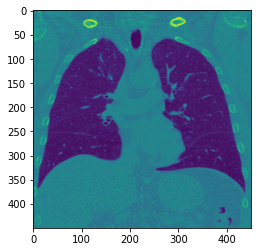

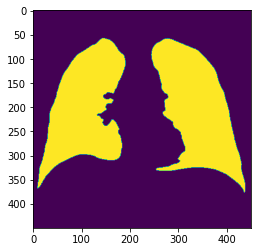

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import ndimage
%matplotlib inline 

imageArray = np.load('Data2/lungCTSlice.npy')
maskArray = np.load('Data2/lungMask.npy')
plt.figure(1)
plt.imshow(imageArray)
plt.figure(2)
plt.imshow(maskArray)

## Thresholding

Exercise 1.1. Please implement thresholding function and test it on -500, -300, and -150 threshold levels. Please visualize these results of thersholding in the similar way the lungMask.npy is visualized at the description of the assignment.

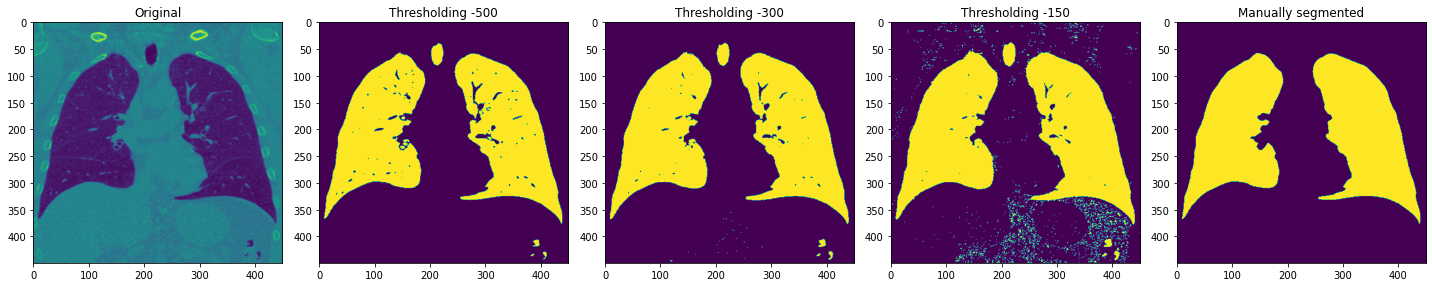

In [ ]:
# implement a function for thresholding 2D arrays
def thresholding(image_array, threshold):
  image = image_array.copy()
  image[image > threshold] = 0
  image[image <= threshold] = 1.
  return image

# implement a function for visualization of thresholding results
def visualize_image(image_array, title=None, save=False, filename=""):
  plt.imshow(image_array)
  if title != None:
    plt.title(title)
  if save==True:
    plt.savefig("./Week3/plots_handin2/" + filename + ".png", dpi=300)
  plt.show()

def visualize_images(subimgs, subtitles=None, nrow=1, figsize=None, save=False, filename=""):
  fig, axes = plt.subplots(nrow, len(subimgs), figsize=figsize)
  for i, (ax, img) in enumerate(zip(axes.flatten(), subimgs, )):
    ax.imshow(img, aspect="auto")
    if subtitles != None:
      ax.set_title(subtitles[i])
  fig.tight_layout()
  if save==True:
    plt.savefig("./Week3/plots_handin2/" + filename + ".png", dpi=300)
  plt.show()  


img1 = thresholding(imageArray, -500)
img2 = thresholding(imageArray, -300)
img3 = thresholding(imageArray, -150)
imgs = [imageArray, img1, img2, img3, maskArray]
subtitles = ["Original", "Thresholding -500", "Thresholding -300", "Thresholding -150", "Manually segmented"]
visualize_images(imgs, subtitles, figsize=(20,4.1))

# Dice coefficient

Dice coefficient is useful to evaluate the results of image segmentation. The Dice coefficient counts pixels that are classified as the object in both manual and automated segmentation (true positives TP), as background in manual segmentation and as the object in automated segmentation (false positive FP), as the object in manual segmentation and as background in automated segmentation (false negative FN) and as background in both manual and automated segmentation (true negative TN)

The Dice coefficient is computed as:
$$DSC = \frac{2*TP}{2*TP + FP + FN} $$

Exercise 1.2. Please implement the Dice coefficient, and test it on the results of lung CT thresholding. Find the optimal threshold by comparing the Dice coefficients for different threshold  values in the interval [-1000; 0]

Exercise 1.3. Please write your reflection on why TN is not used in the Dice coefficient definition?

In [ ]:
import time
start_time = time.time()

# Implement the Dice coefficient calculation (method 1)
def get_dsc(reference, test):
  tp, fn, tn, fp = 0,0,0,0
  for i in range(reference.shape[0]):
    for j in range(test.shape[1]):
      if reference[i,j]==1:
        if test[i,j]==1:
          tp += 1
        else:
          fn += 1
      else:
        if test[i,j]!=1:
          tn += 1
        else:
          fp += 1
  return 2*tp / (2*tp + fp + fn)

print("DSC thresholding -500", get_dsc(maskArray, img1))
print("DSC thresholding -300", get_dsc(maskArray, img2))
print("DSC thresholding -150", get_dsc(maskArray, img3))

end_time = time.time()
print("\nTime function 1", end_time-start_time, "\n")

start_time = time.time()

# (method 2)
def get_dsc2(man, aut):
  tp =  sum(man[man == 1] == aut[man == 1])
  fn = sum(man[man == 1] != aut[man == 1])
  tn = sum(man[man == 0] == aut[man == 0])
  fp = sum(man[man == 0] != aut[man == 0])
  dsc = 2*tp / (2*tp + fp + fn)
  return dsc

print("DSC thresholding -500: ", get_dsc2(maskArray, img1))
print("DSC thresholding -300: ", get_dsc2(maskArray, img2))
print("DSC thresholding -150: ", get_dsc2(maskArray, img3))

end_time = time.time()
print("\nTime function 2", end_time-start_time, "\n")

# Implement a function for selecting an optimal threshold using the Dice coefficient calculation function 
def get_threshold(manual, original, t_range, show_threshold=False):
  best_dsc = 0
  best_t = None
  for threshold in range(t_range[0], t_range[1], t_range[2]):
    dsc = get_dsc(manual, thresholding(original, threshold))
    if dsc > best_dsc:
      best_dsc = dsc
      best_t = threshold
    if threshold % t_range[2] == 0 and show_threshold:
      print(f"{threshold} {dsc:.5}")
  return best_t

print(f"Optimal threshold: {get_threshold(manual=maskArray, original=imageArray, t_range=(-1000,0,25))}")
optimal_threshold = get_threshold(manual=maskArray, original=imageArray, t_range=(-480,-470,1))
img4 = thresholding(imageArray, optimal_threshold)
print(f"Optimal threshold: {optimal_threshold}, DSC: {get_dsc(maskArray, img4)}")

DSC thresholding -500 0.9775668749646325
DSC thresholding -300 0.9739831323577339
DSC thresholding -150 0.9361611651517567

Time function 1 2.452134609222412 

DSC thresholding -500:  0.9775668749646325
DSC thresholding -300:  0.9739831323577339
DSC thresholding -150:  0.9361611651517567

Time function 2 2.7360899448394775 

Optimal threshold: -475
Optimal threshold: -476, DSC: 0.9778319162323938


# Exercise 2

# Connected Component Decomposition

Thresholding operation does not only mark lung fields but also non-lung image pixels with low intensity. The aim of this subtask is to implement a simple algorithm for the extraction of lung fields form the thresholded image. The lung fields represent the largest dark connected objects. Let’s try to use this information.

Exercise 2.1. Implement the connected component decomposition algorithm. Apply it on the 2D masks representing the optimally thresholded lung CT image. Extract the largest component and discard all other components. Form the lung field mask the correspond to the largest connected components. 

Exercise 2.2. Plot the connected components and the largest connected components.Compute and print the Dice coefficient of the improved lung segmentation.


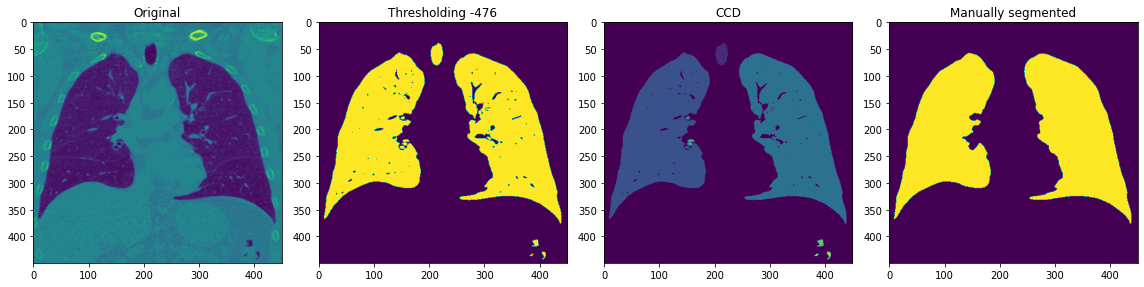

In [ ]:
# Implement a function for connected component decomposition on 2D arrays

def growing(I, V, y, q, t):
  # Look behind and above y
  i,j = y
  if i-1 > 0:
    z = i-1,j
    check_z(I, V, z, q, t)
  if j-1 > 0:
    z = i,j-1
    check_z(I, V, z, q, t)
  # Look below and front y
  if i+1 < I.shape[0]:
    z = i+1,j
    check_z(I, V, z, q, t)
  if j+1 < I.shape[1]:
    z = i,j+1
    check_z(I, V, z, q, t)

def check_z(I, V, z, q, t):
  if I[z] == 1 and V[z] == 0:
      q.append(z)
      V[z] = t

def ccd(image_array):
  I = image_array 
  V = np.zeros(I.shape)
  q = []
  t = 1
  for i in range(I.shape[0]):
    for j in range(I.shape[1]):
      x = i,j
      if I[x] == 1 and V[x] == 0:
        c = 1
        # Append the first pixel to the queue
        q.append(x)
        # Label the first connected component in V
        V[x] = t
        # Until the queue isn't empty do
        while len(q) > 0:
          # Take the first element in the queue and look at neighbours
          y = q.pop()
          c += 1
          growing(I, V, y, q, t)
        t += 1
  return V

# Visualize the result of connected component decomposition using lung CT thresholded 
# with the optimal threshold from the previous subtask
img6 = ccd(thresholding(imageArray, optimal_threshold))
imgs = [imageArray, img4, img6, maskArray]
subtitles = ["Original", "Thresholding -476", "CCD", "Manually segmented"]
visualize_images(imgs, subtitles, figsize=(16,4.1))

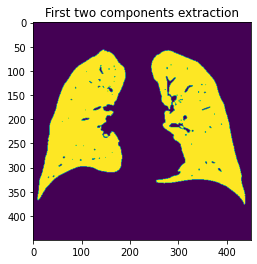

DSC after CCD: 0.9860889655396831


In [ ]:
# Extract largest component(s)
def get_components(image_array):
  components = []
  for n in range(1, int(np.max(image_array))):
    size = np.sum(image_array == n)
    components.append((size, n))
  return sorted(components, reverse=True)

def extract_components(image_array, first_largest, second_largest=None):
  if second_largest == None:
    second_largest = first_largest
  img = image_array.copy()
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i,j] == first_largest or img[i,j] == second_largest:
        img[i,j] = 1
      else:
        img[i,j] = 0
  return img

first_largest = get_components(img6)[0][1]
second_largest = get_components(img6)[1][1]
img7 = extract_components(img6, first_largest, second_largest)
visualize_image(img7, title="First two components extraction")

print(f"DSC after CCD: {get_dsc(maskArray, img7)}")

# Exercise 3

# Morthological operation

Lungs on CT are not only air but also vasculature. Thresholding did not capture lung vasculature and lung segmentation is therefore incomplete. Let’s try to apply morphological operations to include vasculature into the lung segmentation.



Exercise 3.1. Implement morphological dilation and erosion operations. Perform in a consecutive order one dilation and one erosion on the result of the previous subtask. Visualize the obtained result. Find an optimal sequence of dilations and erosions that can maximally improve the Dice coefficient of the lung segmentation.

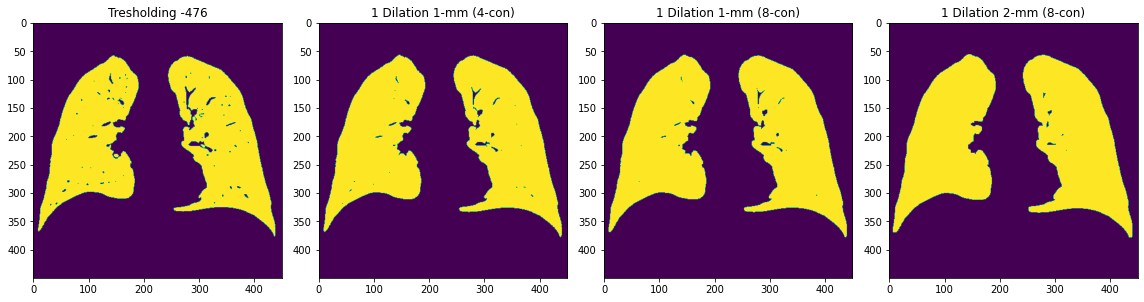

DSC for scipy dilation and my implemented dilation: 1.0


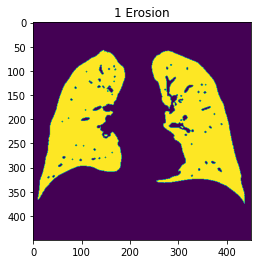

Optimal sequence is: 5D + 5E 
DSC: 0.9960154241645244


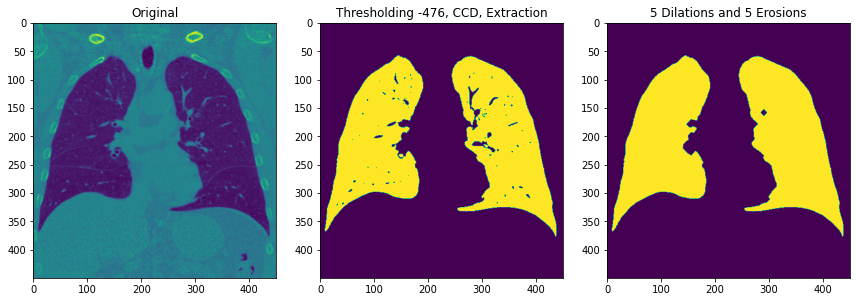

In [ ]:
# Implement a function for morphological dilation and erosion on 2D arrays
def dilation(image_array, p=1, connectivity_8=False, iterations=1):
  I = image_array
  V = np.zeros(I.shape)
  for n in range(iterations):
    for i in range(I.shape[0]):
      for j in range(I.shape[1]):
        if I[i,j] == 1:
          # Set the neightborhood as 1
          if i-p > 0:
            V[i-p,j] =1
          if j-p > 0:
            V[i,j-p] = 1
          if i+p < I.shape[0]:
            V[i+p,j] = 1
          if j+p < I.shape[1]:
            V[i,j+p] = 1
          # Use 8-connectivity
          if connectivity_8:
            if i-p > 0 and j-1 > 0:
              V[i-p, j-p] = 1
            if i+p < I.shape[0] and i-1 > 0:  
              V[i+p, j-p] = 1
            if i-p > 0 and j+1 < I.shape[1]:
              V[i-p, j+p] = 1
            if i+p < I.shape[0] and j+1 < I.shape[1]:
              V[i+p,j+p] = 1 
  return V

def scipy_dilation(image_array, iterations=1):
  return sp.ndimage.morphology.binary_dilation(image_array, iterations=iterations)

def scipy_erosion(image_array, iterations=1):
  return sp.ndimage.morphology.binary_erosion(image_array, iterations=iterations)

# Dilation
img8 = dilation(img7)
img9 = dilation(img7, connectivity_8=True)
img10 = dilation(img7, p=2, connectivity_8=True)
imgs = img7, img8, img9, img10
subtitles = "Tresholding -476", "1 Dilation 1-mm (4-con)", "1 Dilation 1-mm (8-con)", "1 Dilation 2-mm (8-con)" 
visualize_images(imgs, subtitles, figsize=(16,4.3))

sp_img1 = scipy_dilation(img7)
print(f"DSC for scipy dilation and my implemented dilation: {get_dsc(sp_img1, img8)}")

# Erosion
visualize_image(scipy_erosion(img7), title="1 Erosion")

# Implement a function that finds an optimal sequence of dilation and erosion operations 
# (restrict your search to max 5 dilation and 5 erosions).
def morthological_seq(reference, image_array, max_iterations):
  best_dsc = 0
  best_seq = ""
  for i in range(max_iterations+1):
    dsc = get_dsc(reference, scipy_erosion(scipy_dilation(image_array, iterations=i), iterations=i))
    if dsc > best_dsc:
      best_dsc = dsc
      best_seq = f"{i}D + {i}E"
    dsc = get_dsc(reference, scipy_dilation(scipy_erosion(image_array, iterations=i), iterations=i))
    if dsc > best_dsc:
      best_dsc = dsc
      best_seq = f"{i}E + {i}D"
  print(f"Optimal sequence is: {best_seq} \nDSC: {best_dsc}")
  return int(best_seq[0])

best_i = morthological_seq(maskArray, img7, max_iterations=5)

# Implement visualization of the optimal sequence morphological operation sequence and print the Dice coefficient

img11 = scipy_erosion(scipy_dilation(img7, iterations=best_i), iterations=best_i)
imgs = imageArray, img7, img11
subtitles = "Original", "Thresholding -476, CCD, Extraction", "5 Dilations and 5 Erosions"
visualize_images(imgs, subtitles, figsize=(12,4.3), save=True, filename="5dilation_5erosion")

In [ ]:
# To check
def erosion(image=np.ndarray, iterations=1):
  assert list(np.unique(image)) == [0, 1], "The image provided is not binary."

  for iter in range(iterations):
    mask = np.nonzero(image)
    neigh_x, neigh_y = [], []
    V = np.zeros_like(image)
    # For next pixel with intensity 1
    for i, j in zip(mask[0], mask[1]):
      # Look right
      if j+1 <= image.shape[1]:   
        neigh_x.append(i)
        neigh_y.append(j+1)
      # Look down
      if i+1 <= image.shape[1]:   
        neigh_x.append(i+1)
        neigh_y.append(j)
      # Look left    
      if j-1 >= 0:                
        neigh_x.append(i)
        neigh_y.append(j-1)
      # Look up    
      if i-1 >= 0:                
        neigh_x.append(i-1)
        neigh_y.append(j)

      if np.all(image[neigh_x, neigh_y]):
        V[i, j] = 1
      else:
        V[i, j] = 0
      neigh_x, neigh_y = [], []
    image = V.copy()
return V